# CIFAR-10 with Transfer Learning

Previous lesson, we used our own CNN network to classify cats & dogs, and took on the CIFAR-10 challenge. Now, let's tackle that same CIFAR-10 data challenge, but use transfer learning!

Note: since now we're going to go all out in deep learning, it's probably best to have some decent compute available to run this notebook on. So, unless you have a recent mac-book, or you're running this notebook on WSL where you've installed CUDA support for your Nvidia GPU, run this notebook in Google Colab (https://colab.research.google.com/)! Also remember to **change your runtime type to GPU** (see the menu bar in Colab)!



Okay, to get the hang of transfer learning, we'll import our saved model from our **cats&dogs example** (in the saved_models folder), to be used as a feature extractor. This will help with understanding the basic principles of transfer learning.

Next, we'll use some of the pre-trained networks that use state of the art architectures, and are pre-trained on Imagenet.


Let's do the upload of our own model first, because it will take a while to upload to Colab:
- On your left in Colab, you'll see the icon for a directory.
- Click on it, and you should see your session memory, including a default folder 'sample_data'.
    - We're going to drag&drop our cats&dogs model-file below this sample_data folder. So, right into our session memory from Colab. (Note: we could also use the Google Drive option, but this usually takes longer).
- Next, head over to your Computer Vision folder from previous lesson, go to the saved models folder, and drag&drop catdog_model.keras into session memory!
- You will get a warning that states that it will reset your session (so, good thing you turned on the GPU first, right!?), and the upload will start





In [1]:
# Let's make sure we at least are using TensorFlow 2.16, otherwise our saved model will not be able to load
!pip install tensorflow==2.16.1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.1


## Import CIFAR-10 data

Let's go ahead with our Transfer Learning notebook, and let's get the CIFAR-10 data!

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


The CIFAR-10 dataset is a collection of 60,000 **32x32 color images** in 10 different classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each containing 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class, while the training batches contain the remaining images in random order.

Here are the classes in the CIFAR-10 dataset:

0: Airplane, 1: Automobile, 2: Bird, 3: Cat, 4: Deer, 5: Dog, 6: Frog, 7: Horse, 8: Ship, 9: Truck

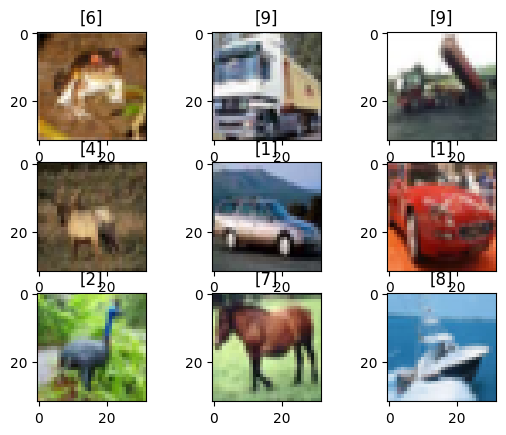

In [4]:
import matplotlib.pyplot as plt

# Assuming you have loaded the dataset as shown above
for i in range(9):  # to show 9 images
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
    plt.title(y_train[i])
plt.show()


As a general sanity rule, it's always a good idea to have a look at your data first. That's why we plotted it above, to get a visual idea. But now, let's also have a look at how our labels are encoded, and if the size is indeed 32x32.

In [5]:
print(y_train[0])
print(X_train.shape)
print(X_test.shape)

unique_y_train, counts_y_train = np.unique(y_train, return_counts=True)
unique_y_test, counts_y_test = np.unique(y_test, return_counts=True)
print("Unique train labels:", unique_y_train)
print("Counts train labels:", counts_y_train)
print("Unique test labels:", unique_y_test)
print("Counts test labels:", counts_y_test)

[6]
(50000, 32, 32, 3)
(10000, 32, 32, 3)
Unique train labels: [0 1 2 3 4 5 6 7 8 9]
Counts train labels: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Unique test labels: [0 1 2 3 4 5 6 7 8 9]
Counts test labels: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Okay, for the info above, we can see that the label y is encoded as integer, between 0 and 9 (so, we'll be needing the **sparse_cross_entropy loss function**, not the more general categorical_cross_entropy which is for one hot encoded labels - see also the Hello World notebook). And, we also notice that our data is perfectedly balanced. Nice!

## Transfer Learning with own model

In [8]:
from tensorflow.keras.models import load_model
# Load the pre-trained model
#base_model = load_model("catdog_model.keras")
base_model = load_model("saved_models/catdog_model.keras")

In [7]:
# If the import fails, it's always a good idea to check the tensorflow version for which you create your .keras model (should be 2.16)
import tensorflow as tf
print(tf.__version__)

2.16.1


Let's check out the models architecture from the saved file:

In [9]:
base_model.summary()

Model: "base_model_catsdogs"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,439,653 (9.31 MB)

 Trainable params: 813,217 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,626,436 (6.20 MB)

Okay. Looks good, although very simple!

In true Transfer Learning style, we want our own Dense layers, after the Flattening part. So, let's get rid of the Dense layers of our pre-trained base model:

In [10]:
# If our Keras model was created via the Sequential method, we could use 'pop()' to get rid of the last layers, but it seems that our model is loaded as a Functional model.
# Remember: Keras has 2 ways to create a model: the simple Sequential API, or the more advanced Functional API

base_model.pop()
base_model.pop()
base_model.summary()

AttributeError: 'Functional' object has no attribute 'pop'

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

new_output = base_model.layers[-3].output  # This is the new last layer after removing two layers

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding new Dense layers in the Functional API style
x = Dense(256, activation='relu')(new_output)  # First new Dense layer with 256 units
x = Dense(128, activation='relu')(x)           # Second new Dense layer with 128 units

# Creating the new model
new_model = Model(inputs=base_model.input, outputs=x)

new_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,928 (6.29 MB)

 Trainable params: 1,638,784 (6.25 MB)

 Non-trainable params: 10,144 (39.62 KB)

Notice the Non-trainable params here. Those are the weights we've frozen, when we've created our new_model.

We need to resize our data, to match the image size used in the pretrained model. Although the pretrained model had a build-in resize layer, this layer is only used while training the layers of the model. But since we'll be freezing those layers, we do need to make sure our input data is resized.

In [13]:
IMG_SIZE=64 # that's the size we used to train our cats&dogs model
X_train_resized = tf.image.resize(X_train, [IMG_SIZE, IMG_SIZE])
X_test_resized = tf.image.resize(X_test, [IMG_SIZE, IMG_SIZE])
print(X_train_resized.shape)
print(X_test_resized.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


In [14]:
from tensorflow.keras.optimizers import Adam
# Compile the model
new_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = new_model.fit(X_train_resized, y_train,
                validation_data = (X_test_resized, y_test),
                batch_size = 32,
                epochs = 7
                )

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.1061 - loss: 10.8302 - val_accuracy: 0.1012 - val_loss: 11.0566
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1086 - loss: 11.1128 - val_accuracy: 0.1000 - val_loss: 11.0571
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.1029 - loss: 11.0687 - val_accuracy: 0.1000 - val_loss: 11.0571
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 20ms/step - accuracy: 0.0983 - loss: 11.0987 - val_accuracy: 0.1000 - val_loss: 11.0571
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.0981 - loss: 11.7986 - val_accuracy: 0.1000 - val_loss: 13.5876


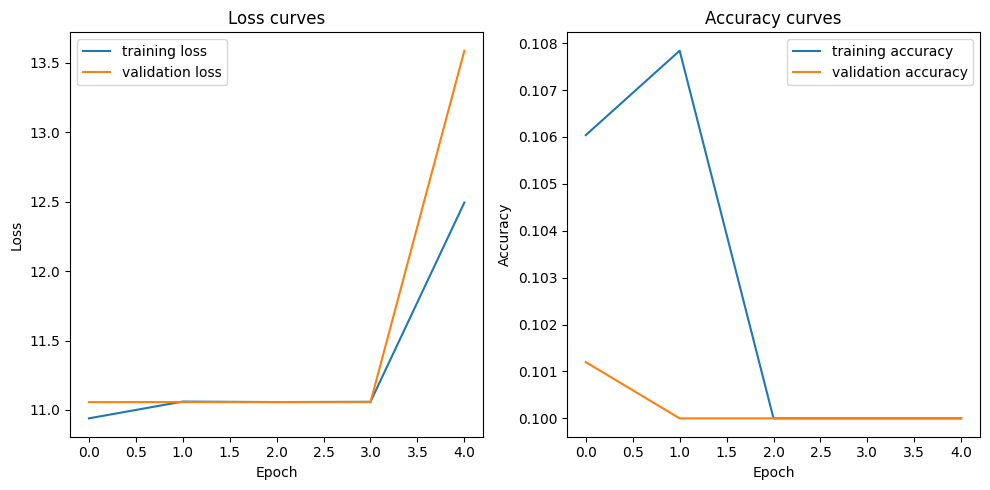

In [16]:
import matplotlib.pyplot as plt

def plotLosses(history):
  # Create a figure and a grid of subplots with a single call
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Plot the loss curves on the first subplot
  ax1.plot(history.history['loss'], label='training loss')
  ax1.plot(history.history['val_loss'], label='validation loss')
  ax1.set_title('Loss curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Plot the accuracy curves on the second subplot
  ax2.plot(history.history['accuracy'], label='training accuracy')
  ax2.plot(history.history['val_accuracy'], label='validation accuracy')
  ax2.set_title('Accuracy curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  # Adjust the spacing between subplots
  fig.tight_layout()
  # Show the figure
  plt.show()


plotLosses(history)

**Not good!**

Not good, at all! Our model isn't picking up any features. The validation accuracy is like 10%, which is the same as guessing (since you have a 1/10 chance of guessing correctly for this dataset).

The reason why our model is so bad, is probably due to the fact that our original base model wasn't that great to begin with. The convolution layers aren't tuned in yet on features of images.

And, we only used it as a feature extractor (frozen weights), but we could take it one step further, and unfreeze the base layers, and tweak them some more (usually with a more gentle learning rate). This is known as fine-tuning a pre-trained model.

So, let's unfreeze those CNN layers, and let it train for a longer period of time. We won't be reducing the learning rate, since our base model was so bad...

In [17]:
for layer in base_model.layers:
    layer.trainable = True

new_model.compile(optimizer=Adam(learning_rate=0.001),  # Normally we would use a lower learning rate here, but since our base model wasn't that great we want to agressively learn...
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

new_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,648,928 (6.29 MB)

 Trainable params: 1,648,928 (6.29 MB)

 Non-trainable params: 0 (0.00 B)

Notice the Non-trainable params again: this time we've unfrozen the entire thing! So everything is trainable!

Now, let's train for some more epochs (entire runs through the training data), and make the batch_size smaller (how many images should be used in the forward pass, after which Adam is used to update the weights in the backwards pass), to see if our network picks up learning.

In [19]:
history = new_model.fit(X_train_resized, y_train,
                validation_data = (X_test_resized, y_test),
                batch_size = 16,
                epochs = 6
                )
plotLosses(history)


Epoch 1/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.1012 - loss: 13.5594 - val_accuracy: 0.1000 - val_loss: 13.5876
Epoch 2/6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.1011 - loss: 13.5570 - val_accuracy: 0.1000 - val_loss: 13.5876
Epoch 3/6
1129/3125 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.1000 - loss: 13.6384

KeyboardInterrupt: 

Nope. Still no good.
But, we could see in our summary that only 10k parameters belonged to the CNN layers, out of the 1.65 million parameters. So, probably our CNN base model just isn't powerfull enough to capture the patterns to identify the CIFAR-10 features.

We could create our own, bigger CNN architecture and train it for a way longer period. But, since Transfer Learning is all about re-using pre-trained networks, why not go ahead and employ the full power of Transfer Learning...

# TensorFlow Hub

TensorFlow Hub (https://www.tensorflow.org/hub/tutorials) is a repository for machine learning models, particularly focused on models that can be used with TensorFlow. The models are now even stored on Kaggle (https://www.kaggle.com/models?tfhub-redirect=true&task=16686). It provides a collection of pre-trained models that you can easily download and integrate into your projects. It's similar to HuggingFace (https://huggingface.co/models), which is more focussed on NLP tasks.

Most common models are already build-in into the TensorFlow framework as well (https://www.tensorflow.org/api_docs/python/tf/keras/applications)

As an example, we'll be comparing two of the most selected models today: resnet50 (https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50V2) versus efficientnetv2: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2S, or https://www.kaggle.com/models/google/efficientnet-v2



In [20]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2, EfficientNetV2S
#import tensorflow_hub as hub


# Preprocessing the data
X_train_resnet = tf.keras.applications.resnet_v2.preprocess_input(X_train)
X_test_resnet = tf.keras.applications.resnet_v2.preprocess_input(X_test)
X_train_eff = tf.keras.applications.efficientnet.preprocess_input(X_train)
X_test_eff = tf.keras.applications.efficientnet.preprocess_input(X_test)

As you can see above, those pretrained models come with their own preprocessing function, which is pretty handy.

Next, we'll use those pretrained networks, trained on the imagenet benchmark, without the top, so without the 'head' of the model. We'll be adding our own 'head' in the following section. We also make sure that the weights of our pre-trained body are frozen, so are untrainable. This way we'll use our model as a feature extractor, without messing with the those weights.

In [21]:
# Load ResNet50V2 / EfficientNetV2S and freeze the layers for feature extraction
base_model_resnet = ResNet50V2(input_shape=(32, 32, 3),
                             include_top=False,
                             weights='imagenet',
                             )

base_model_resnet.trainable = False

base_model_eff = EfficientNetV2S(input_shape=(32, 32, 3),
                             include_top=False,
                             weights='imagenet',
                             )

base_model_eff.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


As stated above, now it's time to place our own 'head' on top of the frozen base-model, aka the body. We'll be using the GAP instead of the Flatten layer, because these pre-trained networks have a large number of CNN layers in them, so we can assume they do a good enough job, so we can get away with GAP instead of Flattening.

But, if you want to experiment with the difference between GAP and Flatten(): go for it!

In [24]:
# Create the model
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(), # we can assume that our base model is now powerfull enough the use GAP instead of Flatten
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes in CIFAR-10
])

# Create the model
model_eff = Sequential([
    base_model_eff,
    GlobalAveragePooling2D(), # we can assume that our base model is now powerfull enough the use GAP instead of Flatten
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Assuming 10 classes in CIFAR-10
])

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Compile the model
model_eff.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now everything is set for training our network, at least our own 'head' on top of the frozen 'body'.

In [25]:
history_resnet = model_resnet.fit(X_train_resnet, y_train,
                validation_data = (X_test_resnet, y_test),
                batch_size = 32,
                epochs = 5
                )

plotLosses(history_resnet)


Epoch 1/5
  92/1563 ━━━━━━━━━━━━━━━━━━━━ 1:04 44ms/step - accuracy: 0.1918 - loss: 2.2334

KeyboardInterrupt: 

It looks like the resnet is overfitting, but to know for sure, we probably need to train the network for a lot more epochs. This way we can get a more nuanced view.

But first, let's do a quick check of the efficientnet model as well...

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 206s 72ms/step - accuracy: 0.3791 - loss: 1.7610 - val_accuracy: 0.5547 - val_loss: 1.3242
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.5238 - loss: 1.3612 - val_accuracy: 0.5181 - val_loss: 1.4009
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5443 - loss: 1.3062 - val_accuracy: 0.5682 - val_loss: 1.2450
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5533 - loss: 1.2707 - val_accuracy: 0.5837 - val_loss: 1.1940
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.5640 - loss: 1.2441 - val_accuracy: 0.5774 - val_loss: 1.2065


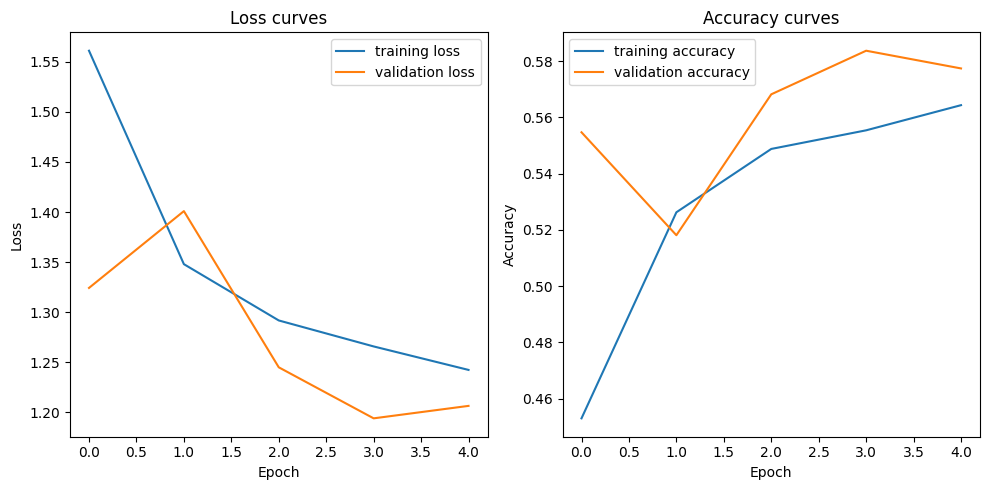

In [21]:
history_eff = model_eff.fit(X_train_eff, y_train,
                validation_data = (X_test_eff, y_test),
                batch_size = 32,
                epochs = 5
                )

plotLosses(history_eff)

This looks a lot better, and also the accuracy looks to be a lot better. Around 56%, which is already way better then our 10% we had in the beginning. Of course, we could keep on training and tweaking to get even better results.

And even then, we could take it even one step further, by unfreezing and really finetuning our model (with a smaller learning rate). But we'll leave those experiments up to you.

To wrap things up, let's check the final accuracy on the test (validation) set, and the confusion matrix of both models.

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step


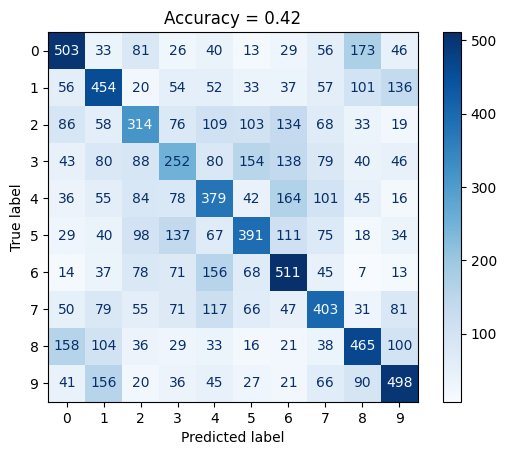

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step


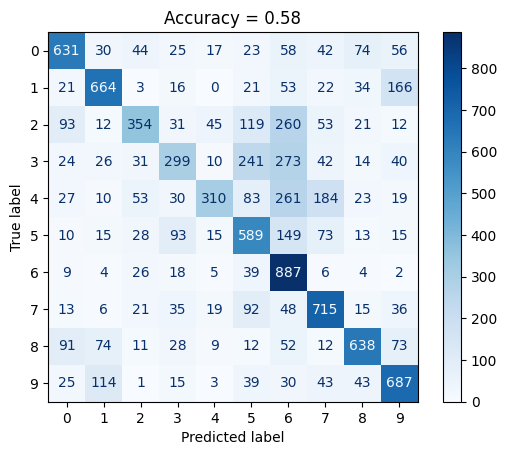

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def plot_confusion(model, X_test, y_test):
  # Generate predictions for all the test images
  predictions = model.predict(X_test)
  # First, let's transform all the prediction into the winners (otherwise each prediction gives us the 10 probabilities, but we only need the winner, the one our network thinks it is)
  pred = np.argmax(predictions, axis=1)
  # Calculate the accuracy
  accuracy = accuracy_score(y_test, pred)
  # Now, compare the true labels of the test set, to our predicted winners
  cm = confusion_matrix(y_test, pred)
  # print(cm)

  # Make the confusion matrix a little more visually attractive
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)

  disp.plot(cmap=plt.cm.Blues)
  # Add a title with the calculated accuracy
  plt.title(f'Accuracy = {accuracy:.2f}')

  plt.show()

plot_confusion(model_resnet, X_test_resnet, y_test)
plot_confusion(model_eff, X_test_eff, y_test)

As stated above: the efficient net is better then the resnet by a considerable margin. Both models do show some difficulty classifying between labels 5-6-7: Dog-Frog-Horse.

This is probably due to the fact that all three are animals, and let's not forget: our images are really really small: 32x32. Both base networks were trained on imagenet images, which were a lot larger to start, so it might be that our pretrained networks were not the best choice for these small image sizes.

Still, they were a lot better then our cats&dogs model.



# Fine-tuning (this will take a long time on CPU)


Let's go ahead with our efficientnet, and demonstrate the finetune method as well.


Note: normally I would train the network with a frozen body for a lot more epochs, before going to the finetuing stage)

In [25]:
model_eff.summary()
# Assuming 'base_model' is your pre-loaded EfficientNet model
number_of_layers = len(base_model_eff.layers)
print(f"\nThe base model has {number_of_layers} layers.")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)        │ (None, 1, 1, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,827,136 (79.45 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 330,518 (1.26 MB)


The base model has 513 layers.


As you can see, the EfficientNet we used (the S - Small version), has 513 layers. As opposed to the resnet50 model, which has 'only' 50 layers. That's why the efficientNet takes a lot longer to load, and to train. It's a way bigger network...

So, let's not unfreeze all layers. Let's keep the first 100 layers of the model frozen, since these have the most basic patterns, and are probably already really good...

Our approach: set every layer of the model to trainable, and then lock the first 100 layers again.

In [26]:
# Fine-tuning
# Unfreeze some of the last layers of the base model
base_model_eff.trainable = True
fine_tune_at = 100  # example layer number to start fine-tuning from (we don't want to fine-tune the very early layers: those will most likely be good enough)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_eff.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model (necessary for the changes to take effect)
model_eff.compile(optimizer=Adam(1e-5),  # Lower learning rate for fine-tuning / before it was 1e-3
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



In [27]:
# Continue training, but only for 2 epochs: just for demonstration purposes

history_finetuned = model_eff.fit(X_train_eff, y_train,
                validation_data = (X_test_eff, y_test),
                batch_size = 32,
                epochs = 2
                )

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 442s 141ms/step - accuracy: 0.1934 - loss: 4.4083 - val_accuracy: 0.2754 - val_loss: 2.4996
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 86s 41ms/step - accuracy: 0.3119 - loss: 2.2515 - val_accuracy: 0.3392 - val_loss: 1.9532


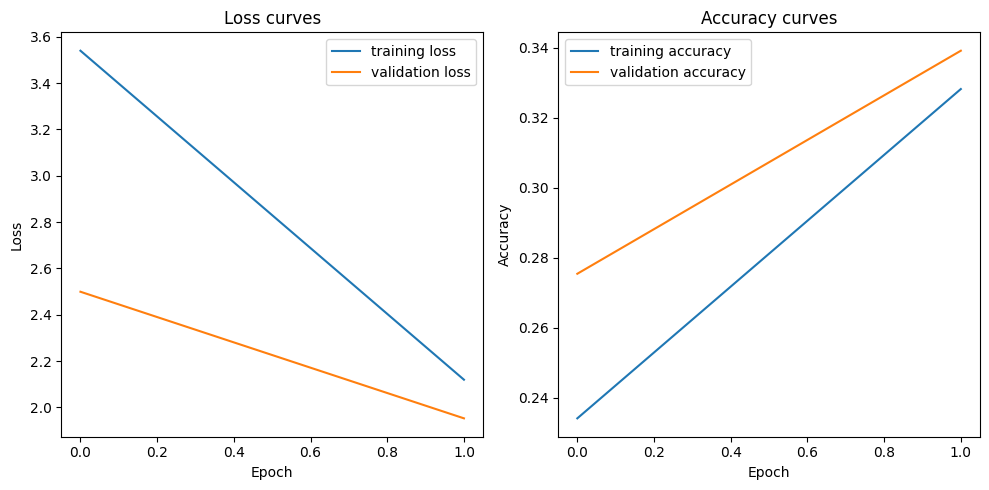

In [28]:
plotLosses(history_finetuned)

313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step


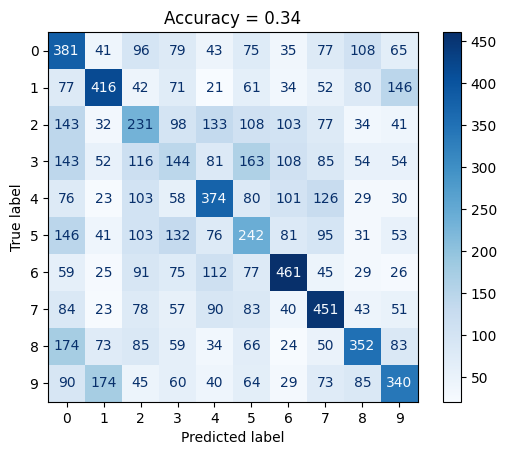

In [29]:
plot_confusion(model_eff, X_test_eff, y_test)

It's a suprise that unlocking the weights after layer 100, seems to do a little harm in the beginning, since my first epoch had an accuracy of around 20%, while we started at around 60%.

Although the model quickly learns in the second epoch. To know for sure if it will perform better, I would have to run it a lot more epochs.

But I'll leave that up to you.